In [1]:
import wandb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pathlib import Path

In [2]:
EXP_CONFIG = {
    "walker": {
        "agent": ["rnd", "hyper_rnd", "icm_apt", "hyper_icm_apt", "hyper_ddpg_rnd"],
        "task": ["walker_stand", "walker_walk", "walker_run", "walker_flip"],
        "seed": [1, 2, 3], 
        "pt_seed": [1, 2, 3],
    },
    "jaco,quadraped": {
        "agent": ["rnd", "hyper_rnd", "icm_apt", "hyper_icm_apt", "hyper_ddpg_rnd"],
        "task": ["jaco_reach_top_left", "jaco_reach_top_right", "jaco_reach_bottom_left", "jaco_reach_bottom_right", "quadruped_walk", "quadruped_run", "quadruped_stand", "quadruped_jump"],
        "seed": [1, 2], 
        "pt_seed": [1, 2]        
    },
    "smaller_dim": {
        "agent": ["rnd", "hyper_rnd", "icm_apt", "hyper_icm_apt", "hyper_ddpg_rnd"],
        "task": ["walker_stand", "walker_walk", "walker_run", "walker_flip", "jaco_reach_top_left", "jaco_reach_top_right", "jaco_reach_bottom_left", "jaco_reach_bottom_right", "quadruped_walk", "quadruped_run", "quadruped_stand", "quadruped_jump"],
        "seed": [1, 2, 3], 
        "rep_dim": [32]
        # "pt_seed": [1]          
    },
    "smaller_dim_baseline": {
    "agent": ["ddpg", "hyper_ddpg"],
    "task": ["walker_stand", "walker_walk", "walker_run", "walker_flip", "jaco_reach_top_left", "jaco_reach_top_right", "jaco_reach_bottom_left", "jaco_reach_bottom_right", "quadruped_walk", "quadruped_run", "quadruped_stand", "quadruped_jump"],
    "seed": [1, 2, 3], 
    "pt_seed": [1]          
    }
}
CONFIG_SUMMARY_KEYS = ["agent", "task", "seed", "pt_seed", "domain"]
EXCLUSIONS = [
    {"agent": "hyper_ddpg_rnd", "pt_seed": 2, "rep_dim": 512},
]
## Num Samples to get from wandb history, depends on how much you log. Make sure it's large enough to include max number of samples.
SAMPLES = 10000

In [14]:
def dict_product(dicts):
        return list(dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

SWEEPS = ["omar-s/url_benchmark/fq1gk59g", "omar-s/url_benchmark/jex9t8dv", "omar-s/url_benchmark/nlq03cnh", "omar-s/url_benchmark/x8g63y90", "omar-s/url_benchmark/c4zbgxal", "omar-s/url_benchmark/dpxxw2mx", "omar-s/url_benchmark/717uodlt"]
# SWEEPS = ["omar-s/url_benchmark/x8g63y90"]

api = wandb.Api()
dfs = []
metrics = ['eval/frame', 'eval/episode_reward']
for sweep in SWEEPS:
    sweep = api.sweep(sweep)
    sweep_id = sweep.id
    if Path(f'saved_dfs/{sweep_id}_done.pk').exists():
        df = pd.read_pickle(Path(f'saved_dfs/{sweep_id}_done.pk'))
        dfs.append(df)
        continue
    sweep_dfs = []
    for run in sweep.runs:
        # assert run.state == 'finished'
        config = run.config
        config = pd.json_normalize(config, sep='.')
        config = {k: v[0] for k, v in config.items()}
        config["domain"] = config["task"].split("_")[0]
        config_summary = {k: v for k, v, in config.items() if k in CONFIG_SUMMARY_KEYS}
        if any([ex.items() <= config.items() for ex in EXCLUSIONS]):
                print("Excluding: ", config_summary, run.url)
                continue
        if run.state != 'finished':
                print("Not finished, not excluded:", config_summary, run.state, run.url)
                continue
                # raise Exception(f"Not finished and not excluded: {run.url}")
        try:
            num_data = config['num_train_frames'] // config['eval_every_frames'] + 1
            run_df =  run.history(samples=SAMPLES)
            run_df = run_df[run_df['eval/episode_reward'].notna()]
            run_df = run_df[metrics].reset_index(drop=True)
            assert run_df.shape[0] == num_data, run.url
            for k, v in config.items():
                if "rep_dim" in k:
                    run_df["rep_dim"] = v
                run_df[k] = v
            run_df['url'] = run.url
            run_df['hyper'] = 'hyper' in config['agent']
            sweep_dfs.append(run_df)
        except Exception as e:
            print("Failed on:")
            print(config_summary, run.url)
            raise e
        sweep_df = pd.concat(sweep_dfs)
        sweep_df.to_pickle(Path(f'saved_dfs/{sweep_id}.pk'))
    dfs.append(sweep_df)
        
df = pd.concat(dfs)


In [31]:
new_df = df[
    (df['old'].isna()) | 
    ((~df['agent'].str.contains('hyper')) & (df['rep_dim'] != 32)) | 
    (df['agent'] == 'hyper_ddpg')
    ]

In [32]:
new_df[CONFIG_SUMMARY_KEYS].groupby(['agent']).nunique()

,task,seed,pt_seed,domain
agent,,,,
ddpg,12,3,1,3
hyper_ddpg,12,3,1,3
hyper_dist_icm_apt,12,3,3,3
hyper_icm_apt,12,3,3,3
icm_apt,12,3,3,3
rnd,12,3,3,3


In [27]:
def check_completeness(df, exp_config, exclusions):
    for c in dict_product(exp_config):
        if any([ex.items() <= c.items() for ex in exclusions]):
            print("Excluding:", c)
        else:
            ## find item
            row = df.loc[(df[list(c)] == pd.Series(c)).all(axis=1)]
            unique_config = row.drop_duplicates(subset=CONFIG_SUMMARY_KEYS)
            # print(len(unique_config))
            if len(unique_config) != 1:
                print("Can't find: ", c)
    # Sanity-check correct number of experiments
    exp_num_exps = len(dict_product(exp_config))
    actual_num_exps = len(df.drop_duplicates(subset=CONFIG_SUMMARY_KEYS))
    print(f'Expected: {exp_num_exps}\tActual: {actual_num_exps}')

In [36]:
# check_completeness(df, EXP_CONFIG["walker"], EXCLUSIONS)
# check_completeness(df, EXP_CONFIG["jaco,quadraped"], [])
check_completeness(df, EXP_CONFIG["smaller_dim"], [])
# check_completeness(df, EXP_CONFIG["smaller_dim_baseline"], [])

Can't find:  {'agent': 'rnd', 'task': 'walker_walk', 'seed': 3, 'rep_dim': 32}
Can't find:  {'agent': 'rnd', 'task': 'quadruped_walk', 'seed': 3, 'rep_dim': 32}
Expected: 180	Actual: 443


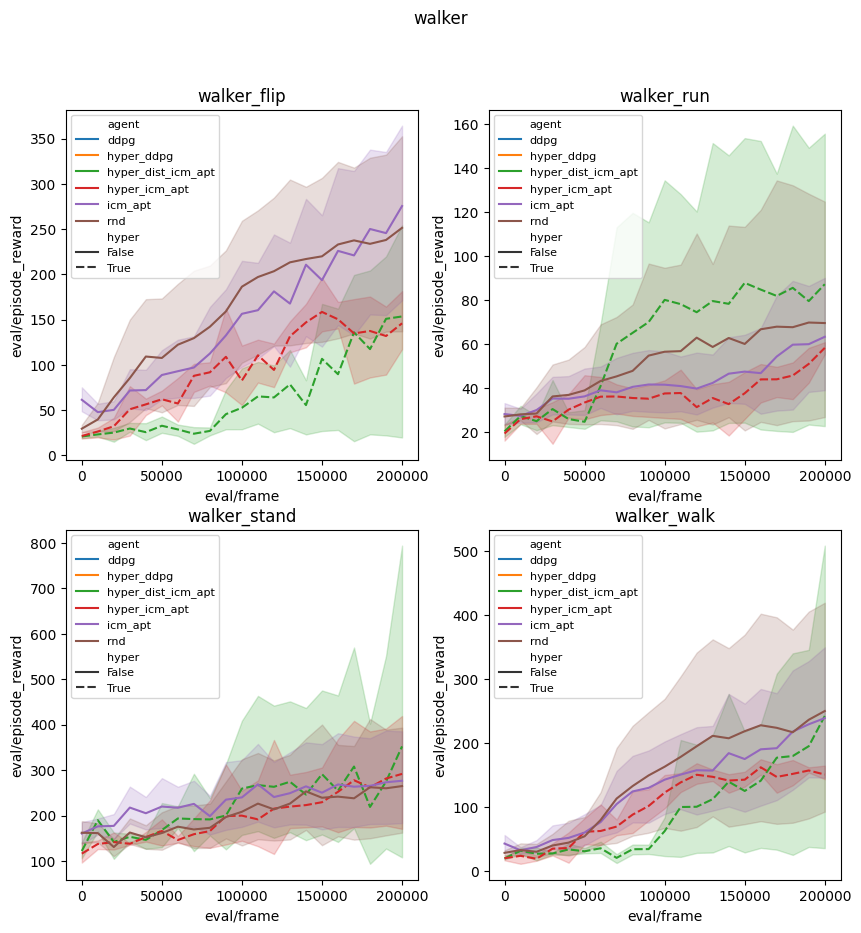

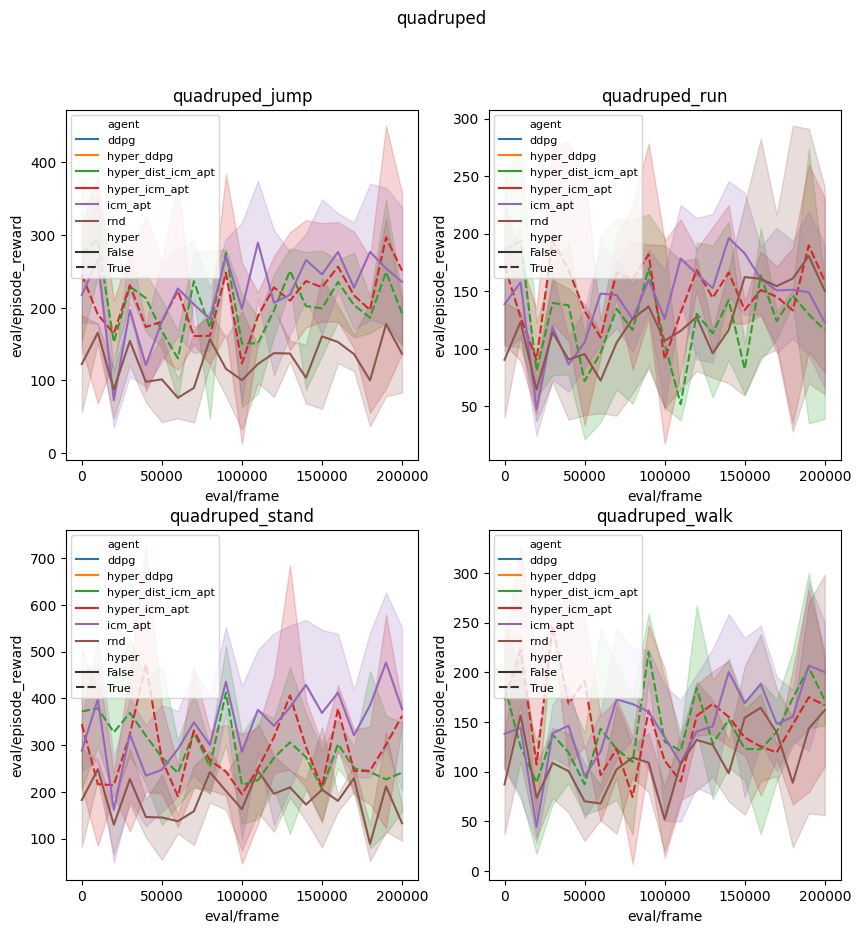

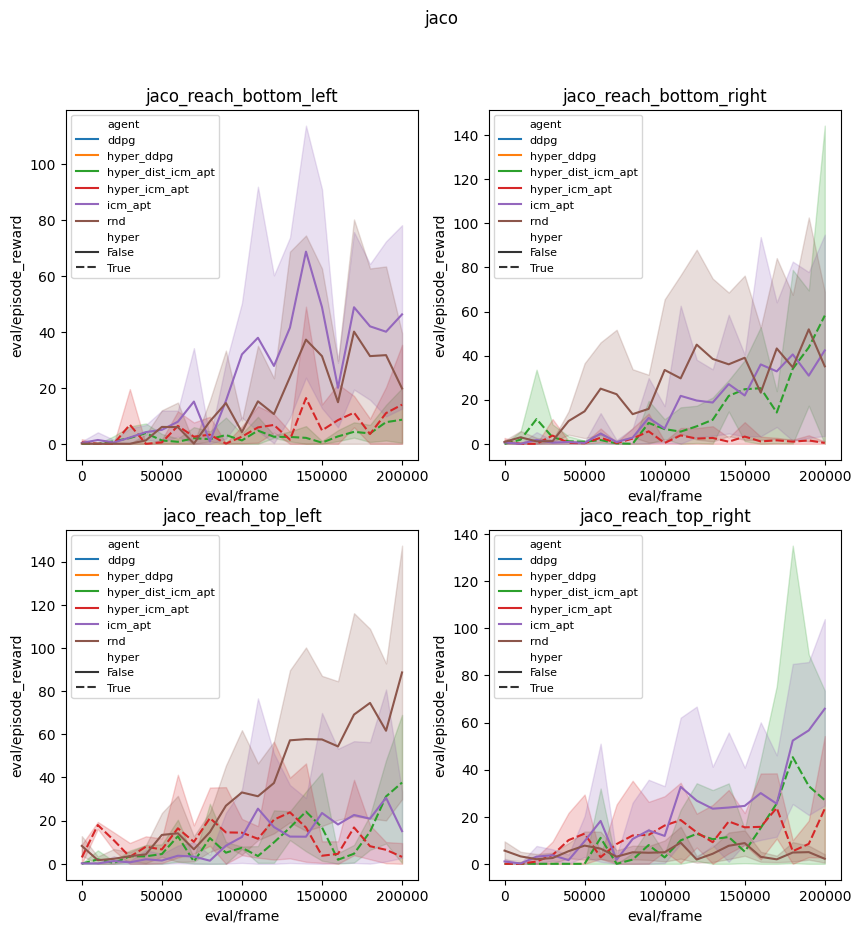

In [33]:
for domain in new_df['domain'].unique():
    plt_df = new_df[new_df['domain'] == domain]
    # plt_df = plt_df.groupby(['agent', 'task', 'domain', 'eval/frame'], as_index=False).max()
    hue_order = sorted(plt_df['agent'].unique())
    tasks = sorted(plt_df['task'].unique())
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i, task in enumerate(tasks):
        row = i // 2
        col = i - row*2
        sns.lineplot(
            ax=ax[row, col], 
            data=plt_df[(plt_df['task'] == task) & (plt_df['rep_dim'] == 512)], 
            # data=plt_df[plt_df['task'] == task], 
            x='eval/frame', y='eval/episode_reward', 
            hue='agent', 
            hue_order=hue_order, 
            # errorbar=None,
            style='hyper')
        ax[row, col].set_title(task)
        ax[row, col].legend(loc='upper left', fontsize=8)
    fig.suptitle(domain)

In [36]:
# df["task"] = '_'.join(df["task"].str.split("_")[1:])
# df['task'] = df["task"].apply(lambda x: '_'.join(x.split("_")[1:]))
# summary = df[df["eval/frame"] == 200000].pivot_table(index=["domain", "task"], columns=["agent"], values=["eval/episode_reward"], aggfunc=[np.mean, np.std])
summary_df = new_df
summary = summary_df[(summary_df["eval/frame"] == 100000)].pivot_table(index=["domain", "task"], columns=["agent"], values=["eval/episode_reward"], aggfunc=[np.mean])
# summary = summary.reorder_levels([1, 2, 0], axis=1)
# summary = summary.sort_index(axis=1, level=1)
# summary = summary.droplevel(0, axis=1)
summary = summary.style.format(precision=0).highlight_max(axis=1, color='green')

# summary.columns = summary.columns.droplevel(level=1)
# def sjoin(x): 
#     x = x[x.notnull()]
#     return f'{round(x[0])} ({round(x[1])})'
# summary.groupby(level=0, axis=1).apply(lambda x: x.apply(sjoin, axis=1))

summary

In [88]:
test = df[(df["eval/frame"] == 200000)&(df["rep_dim"].notna())][CONFIG_SUMMARY_KEYS + ['eval/episode_reward', 'rep_dim', "eval/frame"]].groupby(['agent', 'task', 'rep_dim'], as_index=False).sample(n=2)
test
# test[test['seed'] != 3]

,agent,task,seed,pt_seed,domain,eval/episode_reward,rep_dim,eval/frame
20,hyper_ddpg_rnd,jaco_reach_bottom_left,3,3,jaco,0.099490,32.0,200000.0
20,hyper_ddpg_rnd,jaco_reach_bottom_left,2,2,jaco,5.685944,32.0,200000.0
20,hyper_ddpg_rnd,jaco_reach_bottom_left,1,1,jaco,0.845910,512.0,200000.0
20,hyper_ddpg_rnd,jaco_reach_bottom_left,2,2,jaco,51.761302,512.0,200000.0
20,hyper_ddpg_rnd,jaco_reach_bottom_right,1,1,jaco,9.377026,32.0,200000.0
...,...,...,...,...,...,...,...,...
20,rnd,walker_stand,2,3,walker,106.853995,512.0,200000.0
20,rnd,walker_walk,2,2,walker,27.262104,32.0,200000.0
20,rnd,walker_walk,1,1,walker,34.696932,32.0,200000.0
20,rnd,walker_walk,1,2,walker,607.754221,512.0,200000.0


In [50]:
7*3*12

252

In [41]:
df[(df["task"]=="walker_walk") & (df["rep_dim"] == 32)][["agent", "url"]].drop_duplicates().style

,agent,url
0,rnd,https://wandb.ai/omar-s/url_benchmark/runs/4xlmt5au
0,hyper_icm_apt,https://wandb.ai/omar-s/url_benchmark/runs/31bci2uy
0,hyper_ddpg_rnd,https://wandb.ai/omar-s/url_benchmark/runs/3utx6qv2
0,icm_apt,https://wandb.ai/omar-s/url_benchmark/runs/rlugm0y8
0,hyper_rnd,https://wandb.ai/omar-s/url_benchmark/runs/3lf99iy8
